In [46]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# import classsfier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections

# other libraries

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import make_pipeline as imbalanced_make_pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import KFold, StratifiedKFold
from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


In [9]:
# read credit card data

df = pd.read_csv('D:/Study/DataScience/Data/creditcard.csv')

In [12]:
# find null values

df.isnull().sum().max()

0

In [16]:
# Find unique values of non-fraud and fraud classes

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [32]:
# find percentage of fraud and non-fraud classes

print('Percentage of Non-Fraudelent Class : {:0.2f}%'.format(len(df[df['Class'] == 0])/ len(df.index)*100))
print('Percentage of Fraudelent Class : {:0.2}%'.format(len(df[df['Class'] != 0])/ len(df.index)*100))

Percentage of Non-Fraudelent Class : 99.83%
Percentage of Fraudelent Class : 0.17%


In [43]:
# Scale the data ..
# since all the columns are scaled excepi amount and time. lets scale these two columns

# import modules for scaling

from sklearn.preprocessing import StandardScaler, RobustScaler

# we will use robust scaler as it is less prone to outliers

rob_scaler = RobustScaler()

df['scaled_time'] = rob_scaler.fit_transform((df['Time']).values.reshape(-1, 1))
df['scaled_amount'] = rob_scaler.fit_transform((df['Amount']).values.reshape(-1, 1))

In [44]:
# now drop old amount and time columns

df.drop( columns= ['Time', 'Amount'], inplace= True)

In [45]:
df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'scaled_time',
       'scaled_amount'],
      dtype='object')

In [55]:
# split the dataset before using under sampling or over sampling techniques in order to use the original test dataset for testing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df)*100,2), '% of the data')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100,2), '% of the data')

# define feature and target variables

X = df.drop(columns=['Class'])

y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

No Frauds 99.83 % of the data
Frauds 0.17 % of the data


In [63]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_time,scaled_amount
48386,-0.950891,1.571234,2.251255,2.907859,-0.608814,0.453746,-0.119901,0.760844,-1.424009,0.551279,...,-0.646894,-0.030603,0.494323,-0.031074,0.000912,0.216938,0.086358,0,-0.482548,-0.233215
229712,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,-4.063098,...,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1,0.720521,-0.290924
205469,0.002952,0.749106,0.141228,-0.792770,0.689749,-0.512287,0.846587,0.010089,-0.231384,-0.238491,...,-0.534363,0.022032,-0.481086,-0.490197,0.151705,0.243320,0.082489,0,0.599960,-0.270104
124176,-0.356326,1.435305,-0.813564,1.993117,2.055878,-0.543579,0.487691,0.085449,-0.536352,-2.231209,...,-0.687874,-0.267003,-1.158480,0.271460,-0.155397,0.114328,0.101526,1,-0.087994,-0.293440
151807,-3.552173,5.426461,-3.731810,6.679062,-2.187543,2.433940,-8.748110,-12.108284,-2.856359,-5.665862,...,2.510980,0.953933,-0.542506,-0.620152,0.406013,0.023025,0.164741,1,0.136268,0.161951


In [64]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


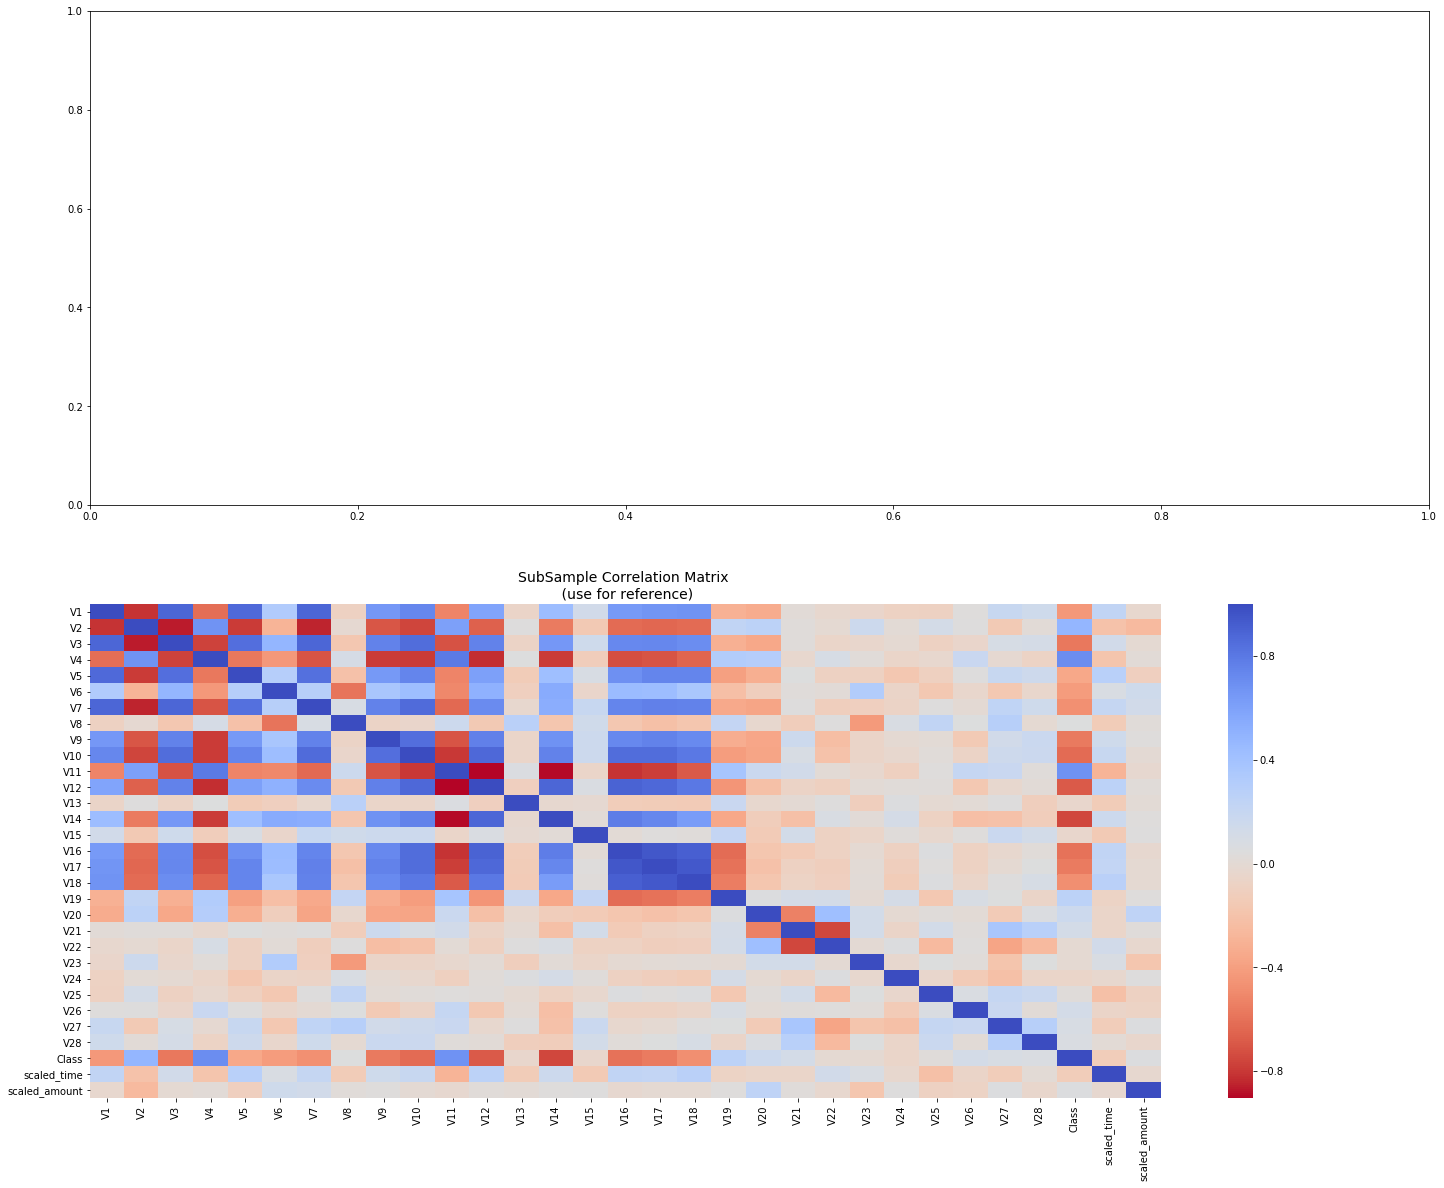

In [68]:
# plot heatmap to find out correlation between the features
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()